# Clustering To Explore Neighbourhoods
## Review
In the last post, we reviewed some of the visualizations we made via datashader and learned a few things about the neighbourhoods in NYC. As someone who is not from NYC, has never lived in NYC, and has only ever visited Manhattan and Brooklyn (and even then, my exposure is quite limited), I was really amazed at how hard of a boundary there were between different neighbourhoods and different types / severity of offenses! I don't think the takeaways are mindblowing as I'm sure someone living in the area is familiar with the general safety of the boroughs, but I came to these conclusions with a MacBook, some chips and guac, and a couch in the comfort of my home here in Edmonton, Alberta... the NY of Canada.

![](https://a1.cdn-hotels.com/cos/production183/d888/1c4131d0-86eb-11e6-a741-0242ac110051.jpg)

The resemblance is _**uncanny**_.

Point being I'm learning via data, and data alone. I'm not saying that looking at this data is a substitute for being there either - By not being there, I have to be comfortable with the fact that I have no supporting information _**outside**_ of the data. This dataset only has a handful of columns, but surely there is information which is not feasible for the NYPD to collect. In fact, there's probably data that the NYPD has not even made open to the public! If we think about something like Grand Larceny, there can be so many other factors that may describe the crime and tell a story within itself... the square footage of the unit, the value of goods stolen, the ethnicity / race of the criminal / victim... there are pretty much endless data points we can capture if we want to get really technical and creative, but obviously there is a balance between how much data you _**can**_ collect vs how much data you _**do**_ collect.

Regardless, it's pretty cool to be learning through data, and data alone. Reminds me of when I tried to [predict the All-NBA players](https://strikingmoose.com/2017/07/31/predicting-2016-2017-all-nba-teams-end-to-end/). If I knew how to run a gradient boosted tree, I basically didn't have to know _**anything**_ about basketball. A scary though, and obviously not always the right train of thought, but always crazy to see where data, alone, can pave the way.

## Contextualizing Visualizations
I want to take a few minutes to write about the use of visualiations, and why the title of this post is on clustering.

The datashader visualizations were beautiful and really informative, but visualizations themselves have pitfalls as well - We gain simplicity and clarity by eliminating detail. I mean, isn't that the whole point of a visualization anyways? Why use a visualization if the data was simple? We make visualizations in the first place because our dataset is too complicated to look at in a tabular form! The inner workings of datashader is based on this principal. Instead of looking at each point individually, datashader aggregates by a more feasible approach for a computer screen... the pixel! Each pixel is summarized based on the data points that fall into that pixel's boundary, and the data is summarized that way.

In datashader, we use the **eq\_hist** color method which tries to let each shade of color in our color gradient / map represent an equal _**amount of samples**_ in our entire dataset. When we apply this coloring method, we lose a realistic handle on the magnitude of our data. eq\_hist is literally _**manipulating the values of the data to appease our eyes**_.

When we categorize the data by the offense level or offense type, we are only looking at 3-4 categories at a time. What about all the other categories? For now, we've just left them out of the visualization altogether. Is this the right thing to do? Well, it really depends on the question we're trying to answer, doesn't it? I realize I came into this entire exercise without any real objectives other than to just learn a bit more about crime in NYC, but when I was using datashader, I was inherently doing a geographical analysis. The map we generated below

<img src="https://s3.ca-central-1.amazonaws.com/2017edmfasatb/nypd_complaints/images/35_nypd_complaints_offense_type_edited.png" width="500">

showed 3 / 10 possible values we had for the OFFENSE\_DESCRIPTION column (which, itself, was grouped down from 50+ categories). By ignoring the data, we are making the same conscious decision that we made when we decided to visualize in the first place. We want to look at the data through a _**different lens**_ in order to get a different perspective. Whether that perspective is the right one to take to answer that specific question... that's where the art of it comes into play. When I created that graph, I had a general sense that wealthier neighbourhoods experienced more Grand Larceny and lesser well-off neighbourhoods experienced more Dangerous Drug offenses while Harrassment was widespread throughout all of NYC. That visualization worked out perfectly for me because the boundaries were so clearly defined across the 3 offense types. The reality of the situation is that I feel uneasy plotting anything over 3-4 categories per map. Can you imagine a map with 10 categories, let alone 50? Can we even process all the colors? Can we even fit a legend on the plot? Visualization inherently has the ability to only summarize a limited amount of information due to our own limitations as humans.

## Clustering
I'm now feeling a bit uneasy because of I've ignored so many types of offenses... But wait, didn't I ignore them in the first place so I could make my visualization simpler to understand? Man... this is confusing...

<img src="https://i.giphy.com/media/l2R01mSIsazqNQ7ks/giphy.webp" width="400">

You know, it just comes down the fact that I'm not coming into this project with any specific objective. I'm looking for some type of finding, but I don't know which 8 questions I need to ask to get there. I'm digging for gold, but I haven't a clue where to look or what tools I need... hell... I don't even know if it's _**gold**_ I'm looking for! That's what this blog is for right...? To have a sandbox where nobody judges me and I can fail as much as I want!

<img src="https://media.collegetimes.com/uploads/2016/02/09152603/laughing-then-crying.gif" width="500">

Because I'm feeling so sensitive to those offenses that I ignored, I want to find a middle ground between looking at the tabular data and and looking at a limited number of categories on a map.

In comes clustering.

When I was checking out one of the [Kaggle NYC Taxi competition kernels](https://www.kaggle.com/gaborfodor/from-eda-to-the-top-lb-0-367), I noticed a super interesting use of clustering. Yes, yes, blah, blah I'm naive, I get it, but it still was really cool for me to see. About a third of a way down the notebook, the kaggler uses K-means clustering to actually cluster all the taxi data into _**regions**_, and these regions loosely represent a small neighbourhood in NYC. Ideally, we would have the boundaries of each neighbourhood defined in code so we can explicitly define each neighbourhood rather than _**approximating**_ their definition, but in the case of taxis, the hard boundaries may not matter anyways because taxis run in and out of neighbourhoods continuously. Oh yea, also we don't have the boundaries in code, so... yeah. This kaggler uses clustering to see if the neighbourhood the taxis are leaving from has a huge impact on the trip duration.

In my case, I could also use clustering to define my data into 20 or so clusters. If I approximate NYC as 20 clusters of neighbourhoods, I might be able to better _**view**_ the data. Again, we're losing detail here as we're summarizing 5 million points into 20 clusters, but it will give us more detail than the map did as we'll be able to just look at the offense statistics / averages for a manageable amount of data samples (one row of data for each cluster).

## Spark ML
Because we are working with the full dataset again, we need to (or want to because our dataset isn't that big anyways) bring Spark back. Another reason for Spark's dominance is that it comes with a _**distributed, out of the box, easy to use machine learning library, Spark ML**_. Spark ML has a K-means clustering algorithm built in - lucky for us!

#### Initial Setup & Config

In [28]:
import os
os.system("sudo pip install findspark sql_magic pyspark_dist_explore seaborn")

0

In [29]:
# Use findspark package to connect Jupyter to Spark shell
import findspark
findspark.init('/usr/lib/spark')

# Load SparkSession object
import pyspark
from pyspark.sql import SparkSession

# Load other libraries
from datetime import datetime
from pyspark.sql import functions as F
from pyspark.sql.types import DateType
from functools import reduce
import pandas as pd
import numpy as np
import seaborn as sns

# Graphing with matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

# Initiate SparkSession as "spark"
spark = SparkSession\
    .builder\
    .getOrCreate()

# Load sql_magic and connect to Spark
%load_ext sql_magic
%config SQL.conn_name = 'spark'

The sql_magic extension is already loaded. To reload it, use:
  %reload_ext sql_magic


In [3]:
%%time
# Read NYPD Complaint Data
df_filtered = spark.read.parquet("s3n://2017edmfasatb/nypd_complaints/data/df_filtered.parquet")

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 16.4 s


In [4]:
df_filtered.count()

5336177

In [5]:
df_filtered.printSchema()

root
 |-- COMPLAINT_NUMBER: integer (nullable = true)
 |-- COMPLAINT_START_TIMESTAMP: timestamp (nullable = true)
 |-- COMPLAINT_END_TIMESTAMP: timestamp (nullable = true)
 |-- REPORTED_DATE_TIMESTAMP: timestamp (nullable = true)
 |-- COMPLAINT_START_TIMESTAMP_YEAR: string (nullable = true)
 |-- COMPLAINT_START_TIMESTAMP_MONTH: string (nullable = true)
 |-- COMPLAINT_START_TIMESTAMP_DAY: string (nullable = true)
 |-- COMPLAINT_START_TIMESTAMP_WEEKDAY: string (nullable = true)
 |-- COMPLAINT_START_TIMESTAMP_HOUR: string (nullable = true)
 |-- COMPLAINT_END_TIMESTAMP_YEAR: string (nullable = true)
 |-- COMPLAINT_END_TIMESTAMP_MONTH: string (nullable = true)
 |-- COMPLAINT_END_TIMESTAMP_DAY: string (nullable = true)
 |-- COMPLAINT_END_TIMESTAMP_WEEKDAY: string (nullable = true)
 |-- COMPLAINT_END_TIMESTAMP_HOUR: string (nullable = true)
 |-- REPORTED_DATE_TIMESTAMP_YEAR: string (nullable = true)
 |-- REPORTED_DATE_TIMESTAMP_MONTH: string (nullable = true)
 |-- REPORTED_DATE_TIMESTAMP_DAY:

## K-Means Clustering

![](https://www.projectrhea.org/rhea/images/e/ef/RunyanKmeans.gif)

Why not start with a gif that basically explains everything. I'm not even sure what else I need to say haha. K-Means clustering is an iterative method which finds natural clusters of data samples.

To start off, we have to tell K-Means _**how many clusters**_ we want. K-Means, unfortunately, doesn't tell this us explicitly (although we can use within-cluster error metrics to help us tune this). The traditional use case of clustering is a bit different from what we're using it for in this project. Traditionally, maybe you work on a product team and you're trying to figure out which users to offer discounts to. Maybe you have 3 tiers of discounts you'd like to give, and you'd like K-Means to find these 3 groups for us naturally based on historical data. We'd go into K-Means saying we want 3 explicit groups and let the algorithm to the rest.

In this project, we're kinda using clustering to represent general regions across NYC. Do we care if we represent NYC as 20 or 21 clusters? Maybe 22? Why don't way go crazy and say 23? It really doesn't matter because I'm just building general clusters to break out the city into some arbitrary number that will help me view some summary statistics by geography. I'm not explicitly saying "New York can only have 20 neighbourhoods, and that's final!".

<img src="http://cdn4.gurl.com/wp-content/uploads/2014/03/scandal-disagree.gif" width="400">

K-Means iterates between two steps:
- Updating cluster assignments
- Updating cluster centres

Once we tell K-Means how many clusters we're looking for, K-Means _**randomly assigns cluster centres**_ in the dimensional space that we've given it. The hope, through iteratively finding new cluster centres, is that the cluster centres and assignments will eventually represent natural spatial clusters in the data.

In the clustering gif above, we see what most would probably perceive as 3 clusters in the data:
- Top left
- Top right
- Bottom right

Originally, the cluster centres are in the bottom left corner where there is no cluster, and every point is classified under the blue cluster. However, after updating the cluster centre the first time, we see some red starting to emerge. Soon enough, the cluster centres have auto-magically found the natural clusters that our eyes saw. WOW!

<img src="https://media.tenor.com/images/136313988be72de056952b46f455868e/tenor.gif" width="250">

The magic behind the scenes is basically a single cluster mean calculation every iteration. Yeah... I don't really have anything else to add to that lol.

The last thing I will say is that, sometimes, the structure of the data will make it such that different initilization locations of the cluster centres yield different cluster assignments upon convergence. For our example, it shouldn't matter here as our clusters ar a bit arbitrary to begin with.

Let's try it out!

In [6]:
from pyspark.ml.clustering import KMeans

# Set seed for ability to reproduce results, 20 clusters
kmeans = KMeans(k = 20, seed = 1)
model = kmeans.fit(df_filtered[['LAT', 'LON']])

IllegalArgumentException: 'Field "features" does not exist.'

Hmm, it looks like we need to [transform the dataframe into vectors first...](https://stackoverflow.com/questions/40838893/pyspark-using-dataframe-in-ml-algorithms) This stackoverflow answer actually links to some official Spark documentation [giving an example of this transformation as well](https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.clustering.KMeans).

In [7]:
from pyspark.ml.feature import VectorAssembler

# Initiate and transform columns into vector
vecAssembler = VectorAssembler(inputCols = ['LAT', 'LON'], outputCol = "features")
k_means_input = vecAssembler.transform(df_filtered)

In [8]:
%%time
# Refit model
model = kmeans.fit(k_means_input[['features']])

CPU times: user 24 ms, sys: 0 ns, total: 24 ms
Wall time: 1min 23s


Took about a minute to create the model. Let's assign the clusters back to the data as a separate column of data.

In [9]:
%%time
# Use model to assign the samples a cluster to belong to
prediction = model.transform(k_means_input[['features']])
print(prediction.head(5))

[Row(features=DenseVector([40.8288, -73.9167]), prediction=0), Row(features=DenseVector([40.6973, -73.7846]), prediction=10), Row(features=DenseVector([40.8026, -73.9451]), prediction=19), Row(features=DenseVector([40.6545, -73.7263]), prediction=10), Row(features=DenseVector([40.738, -73.9879]), prediction=6)]
CPU times: user 4 ms, sys: 4 ms, total: 8 ms
Wall time: 2.58 s


In [11]:
# Since there are no common column between these two dataframes add row_index so that it can be joined
df_filtered_indexed = df_filtered.withColumn('row_index', F.monotonically_increasing_id())
df_filtered.unpersist()

prediction_indexed = prediction.withColumn('row_index', F.monotonically_increasing_id())
prediction.unpersist()

DataFrame[features: vector, prediction: int]

In [12]:
# Perform join on our generated ID row_index
df_predicted = df_filtered_indexed.join(prediction_indexed, on = ['row_index'], how = 'left').drop('row_index')
df_filtered_indexed.unpersist()
prediction_indexed.unpersist()

DataFrame[features: vector, prediction: int, row_index: bigint]

In [14]:
# Preview results
df_predicted.head(2)

[Row(COMPLAINT_NUMBER=101109527, COMPLAINT_START_TIMESTAMP=datetime.datetime(2015, 12, 31, 23, 45), COMPLAINT_END_TIMESTAMP=datetime.datetime(2015, 12, 31, 23, 45), REPORTED_DATE_TIMESTAMP=datetime.datetime(2015, 12, 31, 0, 0), COMPLAINT_START_TIMESTAMP_YEAR='2015', COMPLAINT_START_TIMESTAMP_MONTH='12', COMPLAINT_START_TIMESTAMP_DAY='31', COMPLAINT_START_TIMESTAMP_WEEKDAY='Thu', COMPLAINT_START_TIMESTAMP_HOUR='23', COMPLAINT_END_TIMESTAMP_YEAR='2015', COMPLAINT_END_TIMESTAMP_MONTH='12', COMPLAINT_END_TIMESTAMP_DAY='31', COMPLAINT_END_TIMESTAMP_WEEKDAY='Thu', COMPLAINT_END_TIMESTAMP_HOUR='23', REPORTED_DATE_TIMESTAMP_YEAR='2015', REPORTED_DATE_TIMESTAMP_MONTH='12', REPORTED_DATE_TIMESTAMP_DAY='31', REPORTED_DATE_TIMESTAMP_WEEKDAY='Thu', COMPLAINT_LENGTH=0.0, COMPLAINT_LENGTH_ZERO_TIME=True, COMPLAINT_START_REPORTED_LAG=0.0, COMPLAINT_END_REPORTED_LAG=0.0, OFFENSE_DESCRIPTION='OTHER', OFFENSE_RESULT='COMPLETED', OFFENSE_LEVEL='FELONY', JURISDICTION='N.Y. POLICE DEPT', BOROUGH='BRONX', PR

Hmm... that's interesting. Spark doesn't seem to have (or I can't seem to find) a simple concat function like we have in Pandas which just glues the two dataframes together (assuming they are the same dimensions along the axis of concatenation)... I have to do this roundabout process to generate manual IDs and then join the two tables together...

This may seem like a small change, but this actually caused me quite a bit of trouble - 2 days of trouble to be more specific!

This is probably something I would have ended up come across sooner or later anyways, but I kept running out of memory on the join, causing the JVM to crash with the following Java error:

> _**TransportClient: Failed to send RPC**_

I found a [quick and dirty solution here](https://stackoverflow.com/questions/39467761/how-to-know-what-is-the-reason-for-closedchannelexceptions-with-spark-shell-in-y). First, the problem is described as an issue with using Java 8, which allocates more virtual memory. This may cause YARN to lose its association when the Java issue arises.

One suggestion from both the Jira tracker for the bug and the stackoverflow article itself is to actually disable YARN's memory checks. Although this seems dangerous, and I'll be the first to admit this likely isn't the best engineering practice as per the stackoverflow response below:

> Are you aware of the fact that you effectively disabled all the resource checks that YARN applied to your Spark application and in multi-tenant environment the first submission may take all the resources available? It's a very dangerous situation.

I will go ahead anyways because this is a pretty low risk sandbox environment and, really, I'm not working with that large of a dataset in general (1.5GB!). To disable YARN's memory checks, I added the following lines to EMR's custom configuration text box when setting up the cluster:

~~~~
classification=yarn-site,properties=[yarn.nodemanager.pmem-check-enabled=false,yarn.nodemanager.vmem-check-enabled=false]
~~~~

This will set the _**yarn.nodemanager.pmem-check-enabled**_ and _**yarn.nodemanager.vmem-check-enabled**_ parameters to _**false**_ on the _**yarn-site.xml**_ config file.

After making this change, the join worked without crashing and my notebook is still in tact!

<img src="https://s3.ca-central-1.amazonaws.com/2017edmfasatb/nypd_complaints/images/39_emr_ganglia_mem.png" width="600">

A quick look at the Ganglia (resource monitoring tool within our EMR suite) memory graph shows that we were never really too close to reaching the limit of the cluster. Good stuff.

### Viewing Cluster Centers
Let's just really quickly see how many samples are in each cluster and where each cluster lies.

In [16]:
# Add table to SQL Context
df_predicted.createOrReplaceTempView("df_predicted")

In [15]:
cluster_stats_result = %read_sql \
SELECT \
    prediction, \
    COUNT(*) AS NUM_SAMPLES, \
    AVG(LAT) AS LAT_CENTRE, \
    AVG(LON) AS LON_CENTRE \
FROM df_predicted \
GROUP BY \
    prediction

Query started at 05:50:46 AM UTC; Query executed in 0.57 m

Let's see where these cluster centers are.

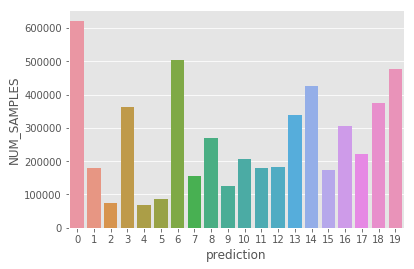

In [30]:
# See distributions of samples in the cluster
sns.barplot(x = "prediction", y = "NUM_SAMPLES", data = cluster_stats_result)

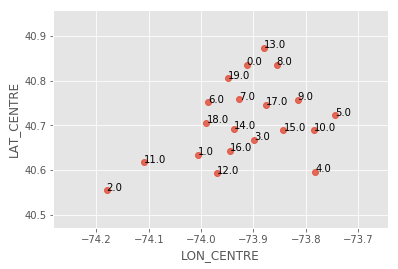

In [41]:
# See cluster centres
fig, ax = plt.subplots()
sns.regplot(x = "LON_CENTRE", y = "LAT_CENTRE", data = cluster_stats_result, fit_reg = False, ax = ax)
cluster_stats_result[['LON_CENTRE','LAT_CENTRE','prediction']].apply(lambda x: ax.text(*x), axis=1);